In [ ]:
# Instalación de las bibliotecas necesarias
!pip install --upgrade scikit-learn xgboost openpyxl

# Importación de bibliotecas
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 5.0 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3


In [ ]:
# Cargar el archivo Excel
df = pd.read_excel('/content/Ejercicio Forecast.xlsx')

# Conversión de la columna de fecha a tipo datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Ordenar los datos por 'codigoarticulo' y 'fecha'
df = df.sort_values(['codigoarticulo', 'fecha']).reset_index(drop=True)

# Crear características adicionales
def create_features(data, pandemia_start='2020-03-01', pandemia_end='2021-12-31', lags=[1,2,3]):
    df = data.copy()
    df['mes'] = df['fecha'].dt.month
    df['tendencia'] = np.arange(len(df))
    pandemia_start = pd.to_datetime(pandemia_start)
    pandemia_end = pd.to_datetime(pandemia_end)
    df['dummy_pandemia'] = ((df['fecha'] >= pandemia_start) & (df['fecha'] <= pandemia_end)).astype(int)
    for lag in lags:
        df[f'cantidad_lag_{lag}'] = df.groupby('codigoarticulo')['cantidad'].shift(lag)
    df = df.dropna().reset_index(drop=True)
    df = pd.get_dummies(df, columns=['mes'], drop_first=True)
    return df

df_feat = create_features(df)

In [ ]:
# Definir las características y la variable objetivo
features = [
    'stock',
    'margen',
    'tendencia',
    'dummy_pandemia',
    'cantidad_lag_1',
    'cantidad_lag_2',
    'cantidad_lag_3'
] + [col for col in df_feat.columns if 'mes_' in col]

target = 'cantidad'

# Definir el preprocesador (escalado de características numéricas)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features)
    ]
)

In [ ]:
# División temporal (80% entrenamiento, 20% prueba)
train_size = int(len(df_feat) * 0.8)
train_df, test_df = df_feat.iloc[:train_size], df_feat.iloc[train_size:]

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from joblib import Parallel, delayed

# Pipelines para modelos lineales con penalización
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

pipeline_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

pipeline_elastic = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet())
])

# Pipelines para Random Forest y XGBoost
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
])

In [ ]:
def smape(y_true, y_pred):
    """
    Calcula el SMAPE (Symmetric Mean Absolute Percentage Error).
    """
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred)
    non_zero = denominator != 0
    return np.mean(2 * diff[non_zero] / denominator[non_zero]) * 100

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Entrena y evalúa un modelo.

    Parámetros:
        model: Pipeline o modelo a entrenar.
        X_train (DataFrame o array): Datos de entrenamiento.
        y_train (Series o array): Objetivos de entrenamiento.
        X_test (DataFrame o array): Datos de prueba.
        y_test (Series o array): Objetivos de prueba.

    Retorna:
        dict: Diccionario con métricas y predicciones.
    """
    # Entrenar el modelo
    model.fit(X_train, y_train)
    # Predicciones
    y_pred = model.predict(X_test)
    # Cálculo de métricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    smape_val = smape(y_test, y_pred)
    return {'rmse': rmse, 'smape': smape_val, 'predictions': y_pred}

In [ ]:
# Inicializar una lista para almacenar los resultados
resultados = []

# Regresión Lineal
result_lr = evaluate_model(pipeline_lr, X_train, y_train, X_test, y_test)
resultados.append({'Modelo': 'Regresión Lineal', 'RMSE': result_lr['rmse'], 'SMAPE': result_lr['smape']})

# Ridge Regression con GridSearchCV
param_grid_ridge = {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}
grid_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=TimeSeriesSplit(n_splits=5), scoring='neg_root_mean_squared_error')
grid_ridge.fit(X_train, y_train)
y_pred_ridge = grid_ridge.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
smape_ridge = smape(y_test, y_pred_ridge)
resultados.append({'Modelo': 'Ridge Regression', 'RMSE': rmse_ridge, 'SMAPE': smape_ridge})

# Lasso Regression con GridSearchCV
param_grid_lasso = {'regressor__alpha': [0.001, 0.01, 0.1, 1.0]}
grid_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=TimeSeriesSplit(n_splits=5), scoring='neg_root_mean_squared_error')
grid_lasso.fit(X_train, y_train)
y_pred_lasso = grid_lasso.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
smape_lasso = smape(y_test, y_pred_lasso)
resultados.append({'Modelo': 'Lasso Regression', 'RMSE': rmse_lasso, 'SMAPE': smape_lasso})

# ElasticNet Regression con GridSearchCV
param_grid_elastic = {
    'regressor__alpha': [0.01, 0.1, 1.0],
    'regressor__l1_ratio': [0.2, 0.5, 0.8]
}
grid_elastic = GridSearchCV(pipeline_elastic, param_grid_elastic, cv=TimeSeriesSplit(n_splits=5), scoring='neg_root_mean_squared_error')
grid_elastic.fit(X_train, y_train)
y_pred_elastic = grid_elastic.predict(X_test)
rmse_elastic = np.sqrt(mean_squared_error(y_test, y_pred_elastic))
smape_elastic = smape(y_test, y_pred_elastic)
resultados.append({'Modelo': 'ElasticNet Regression', 'RMSE': rmse_elastic, 'SMAPE': smape_elastic})

# Random Forest
result_rf = evaluate_model(pipeline_rf, X_train, y_train, X_test, y_test)
resultados.append({'Modelo': 'Random Forest', 'RMSE': result_rf['rmse'], 'SMAPE': result_rf['smape']})

# XGBoost
result_xgb = evaluate_model(pipeline_xgb, X_train, y_train, X_test, y_test)
resultados.append({'Modelo': 'XGBoost', 'RMSE': result_xgb['rmse'], 'SMAPE': result_xgb['smape']})

# Crear un DataFrame con los resultados
df_resultados = pd.DataFrame(resultados)
print(df_resultados)  # Inicializar una lista para almacenar los resultados
resultados = []

# Regresión Lineal
result_lr = evaluate_model(pipeline_lr, X_train, y_train, X_test, y_test)
resultados.append({'Modelo': 'Regresión Lineal', 'RMSE': result_lr['rmse'], 'SMAPE': result_lr['smape']})

# Ridge Regression con GridSearchCV
param_grid_ridge = {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}
grid_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=TimeSeriesSplit(n_splits=5), scoring='neg_root_mean_squared_error')
grid_ridge.fit(X_train, y_train)
y_pred_ridge = grid_ridge.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
smape_ridge = smape(y_test, y_pred_ridge)
resultados.append({'Modelo': 'Ridge Regression', 'RMSE': rmse_ridge, 'SMAPE': smape_ridge})

# Lasso Regression con GridSearchCV
param_grid_lasso = {'regressor__alpha': [0.001, 0.01, 0.1, 1.0]}
grid_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=TimeSeriesSplit(n_splits=5), scoring='neg_root_mean_squared_error')
grid_lasso.fit(X_train, y_train)
y_pred_lasso = grid_lasso.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
smape_lasso = smape(y_test, y_pred_lasso)
resultados.append({'Modelo': 'Lasso Regression', 'RMSE': rmse_lasso, 'SMAPE': smape_lasso})

# ElasticNet Regression con GridSearchCV
param_grid_elastic = {
    'regressor__alpha': [0.01, 0.1, 1.0],
    'regressor__l1_ratio': [0.2, 0.5, 0.8]
}
grid_elastic = GridSearchCV(pipeline_elastic, param_grid_elastic, cv=TimeSeriesSplit(n_splits=5), scoring='neg_root_mean_squared_error')
grid_elastic.fit(X_train, y_train)
y_pred_elastic = grid_elastic.predict(X_test)
rmse_elastic = np.sqrt(mean_squared_error(y_test, y_pred_elastic))
smape_elastic = smape(y_test, y_pred_elastic)
resultados.append({'Modelo': 'ElasticNet Regression', 'RMSE': rmse_elastic, 'SMAPE': smape_elastic})

# Random Forest
result_rf = evaluate_model(pipeline_rf, X_train, y_train, X_test, y_test)
resultados.append({'Modelo': 'Random Forest', 'RMSE': result_rf['rmse'], 'SMAPE': result_rf['smape']})

# XGBoost
result_xgb = evaluate_model(pipeline_xgb, X_train, y_train, X_test, y_test)
resultados.append({'Modelo': 'XGBoost', 'RMSE': result_xgb['rmse'], 'SMAPE': result_xgb['smape']})

# Crear un DataFrame con los resultados
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

                  Modelo        RMSE      SMAPE
0       Regresión Lineal  671.266688  53.040985
1       Ridge Regression  657.193811  51.393240
2       Lasso Regression  671.367201  52.984096
3  ElasticNet Regression  670.353736  51.568552
4          Random Forest  662.403042  50.030838
5                XGBoost  791.973612  62.713504
                  Modelo        RMSE      SMAPE
0       Regresión Lineal  671.266688  53.040985
1       Ridge Regression  657.193811  51.393240
2       Lasso Regression  671.367201  52.984096
3  ElasticNet Regression  670.353736  51.568552
4          Random Forest  662.403042  50.030838
5                XGBoost  791.973612  62.713504


In [ ]:
def process_articulo(articulo, data, features, target, preprocessor, tscv):
    """
    Procesa un único 'codigoarticulo', entrenando y evaluando modelos.

    Parámetros:
        articulo (str): Código del artículo.
        data (DataFrame): DataFrame completo con características.
        features (list): Lista de columnas de características.
        target (str): Nombre de la columna objetivo.
        preprocessor (ColumnTransformer): Preprocesador definido.
        tscv (TimeSeriesSplit): Objeto para validación cruzada.

    Retorna:
        dict: Diccionario con métricas para cada modelo.
    """
    df_art = data[data['codigoarticulo'] == articulo].copy().reset_index(drop=True)

    # Verificar que hay suficientes datos
    if len(df_art) < 50:  # Ajusta según tus necesidades
        return {'codigoarticulo': articulo, 'Mensaje': 'Datos insuficientes'}

    # División temporal
    train_size = int(len(df_art) * 0.8)
    train_df, test_df = df_art.iloc[:train_size], df_art.iloc[train_size:]

    X_train_art, y_train_art = train_df[features], train_df[target]
    X_test_art, y_test_art = test_df[features], test_df[target]

    # Definir los pipelines para los modelos
    modelos = {
        'Regresión Lineal': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', LinearRegression())
        ]),
        'Ridge Regression': GridSearchCV(Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', Ridge())
        ]), {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}, cv=tscv, scoring='neg_root_mean_squared_error'),
        'Lasso Regression': GridSearchCV(Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', Lasso())
        ]), {'regressor__alpha': [0.001, 0.01, 0.1, 1.0]}, cv=tscv, scoring='neg_root_mean_squared_error'),
        'ElasticNet Regression': GridSearchCV(Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', ElasticNet())
        ]), {'regressor__alpha': [0.01, 0.1, 1.0], 'regressor__l1_ratio': [0.2, 0.5, 0.8]}, cv=tscv, scoring='neg_root_mean_squared_error'),
        'Random Forest': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
        ]),
        'XGBoost': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
        ])
    }

    # Inicializar un diccionario para almacenar los resultados
    resultados_art = {'codigoarticulo': articulo}

    # Iterar sobre cada modelo, entrenar y evaluar
    for nombre, modelo in modelos.items():
        try:
            if isinstance(modelo, GridSearchCV):
                modelo.fit(X_train_art, y_train_art)
                y_pred = modelo.predict(X_test_art)
            else:
                modelo.fit(X_train_art, y_train_art)
                y_pred = modelo.predict(X_test_art)

            # Calcular métricas
            rmse = np.sqrt(mean_squared_error(y_test_art, y_pred))
            smape_val = smape(y_test_art, y_pred)

            # Almacenar las métricas
            resultados_art[f'{nombre}_RMSE'] = rmse
            resultados_art[f'{nombre}_SMAPE'] = smape_val
        except Exception as e:
            resultados_art[f'{nombre}_Error'] = str(e)

    return resultados_art

In [ ]:
from joblib import Parallel, delayed

articulos = df_feat['codigoarticulo'].unique()

# Definir TimeSeriesSplit para todo el proceso
tscv = TimeSeriesSplit(n_splits=5)

# Procesar en paralelo usando todos los núcleos disponibles
resultados_finales = Parallel(n_jobs=-1)(
    delayed(process_articulo)(articulo, df_feat, features, target, preprocessor, tscv)
    for articulo in articulos
)

# Convertir los resultados a un DataFrame
df_resultados_finales = pd.DataFrame(resultados_finales)

print(df_resultados_finales.head())

  codigoarticulo  Regresión Lineal_RMSE  Regresión Lineal_SMAPE  \
0     AUACSH1000             153.090447               61.761253   
1     HEELAG1141             162.006869               29.829574   
2     HEELPW1565                    NaN                     NaN   
3      HEELXIW20                    NaN                     NaN   
4       HEFUFG71                    NaN                     NaN   

   Ridge Regression_RMSE  Ridge Regression_SMAPE  Lasso Regression_RMSE  \
0              73.708996               33.714372             137.302508   
1             161.999800               35.566174             157.782744   
2                    NaN                     NaN                    NaN   
3                    NaN                     NaN                    NaN   
4                    NaN                     NaN                    NaN   

   Lasso Regression_SMAPE  ElasticNet Regression_RMSE  \
0               57.431444                   75.012485   
1               28.192868       

In [ ]:
# ===========================================
# 1. Configuración del Entorno
# ===========================================
!pip install --upgrade scikit-learn pandas numpy xgboost openpyxl joblib

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# ===========================================
# 2. Carga y Exploración de Datos
# ===========================================
df = pd.read_excel('Ejercicio Forecast.xlsx')
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values(['codigoarticulo', 'fecha']).reset_index(drop=True)
print(df.head())
print(df.info())
print(df.describe())

# ===========================================
# 3. Definición de Funciones
# ===========================================
def create_features(data, pandemia_start='2020-03-01', pandemia_end='2021-12-31', lags=[1,2,3]):
    df = data.copy()
    df['mes'] = df['fecha'].dt.month
    df['tendencia'] = np.arange(len(df))
    pandemia_start = pd.to_datetime(pandemia_start)
    pandemia_end = pd.to_datetime(pandemia_end)
    df['dummy_pandemia'] = ((df['fecha'] >= pandemia_start) & (df['fecha'] <= pandemia_end)).astype(int)
    for lag in lags:
        df[f'cantidad_lag_{lag}'] = df.groupby('codigoarticulo')['cantidad'].shift(lag)
    df = df.dropna().reset_index(drop=True)
    df = pd.get_dummies(df, columns=['mes'], drop_first=True)
    return df

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred)
    non_zero = denominator != 0
    return np.mean(2 * diff[non_zero] / denominator[non_zero]) * 100

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    smape_val = smape(y_test, y_pred)
    return {'rmse': rmse, 'smape': smape_val, 'predictions': y_pred}

def process_articulo(articulo, data, features, target, preprocessor, tscv):
    df_art = data[data['codigoarticulo'] == articulo].copy().reset_index(drop=True)

    if len(df_art) < 50:
        return {'codigoarticulo': articulo, 'Mensaje': 'Datos insuficientes'}

    train_size = int(len(df_art) * 0.8)
    train_df, test_df = df_art.iloc[:train_size], df_art.iloc[train_size:]

    X_train_art, y_train_art = train_df[features], train_df[target]
    X_test_art, y_test_art = test_df[features], test_df[target]

    modelos = {
        'Regresión Lineal': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', LinearRegression())
        ]),
        'Ridge Regression': GridSearchCV(Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', Ridge())
        ]), {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}, cv=tscv, scoring='neg_root_mean_squared_error'),
        'Lasso Regression': GridSearchCV(Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', Lasso())
        ]), {'regressor__alpha': [0.001, 0.01, 0.1, 1.0]}, cv=tscv, scoring='neg_root_mean_squared_error'),
        'ElasticNet Regression': GridSearchCV(Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', ElasticNet())
        ]), {'regressor__alpha': [0.01, 0.1, 1.0], 'regressor__l1_ratio': [0.2, 0.5, 0.8]}, cv=tscv, scoring='neg_root_mean_squared_error'),
        'Random Forest': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
        ]),
        'XGBoost': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
        ])
    }

    resultados_art = {'codigoarticulo': articulo}

    for nombre, modelo in modelos.items():
        try:
            if isinstance(modelo, GridSearchCV):
                modelo.fit(X_train_art, y_train_art)
                y_pred = modelo.predict(X_test_art)
            else:
                y_pred = evaluate_model(modelo, X_train_art, y_train_art, X_test_art, y_test_art)['predictions']

            rmse = np.sqrt(mean_squared_error(y_test_art, y_pred))
            smape_val = smape(y_test_art, y_pred)

            resultados_art[f'{nombre}_RMSE'] = rmse
            resultados_art[f'{nombre}_SMAPE'] = smape_val
            # Opcional: Almacenar las predicciones
            resultados_art[f'{nombre}_Predicciones'] = y_pred.tolist()
        except Exception as e:
            resultados_art[f'{nombre}_Error'] = str(e)

    return resultados_art

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 60.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.2 which is incompatible.
langchain 0.3.1

In [ ]:
# Crear las características
df_feat = create_features(df)
print(df_feat.head())

# Definir las características y la variable objetivo
features = [
    'stock',
    'margen',
    'tendencia',
    'dummy_pandemia',
    'cantidad_lag_1',
    'cantidad_lag_2',
    'cantidad_lag_3'
] + [col for col in df_feat.columns if 'mes_' in col]

target = 'cantidad'

# Definir el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features)
    ]
)

# Definir TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Obtener todos los códigos de artículo únicos
articulos = df_feat['codigoarticulo'].unique()

# Procesar en paralelo
resultados_finales = Parallel(n_jobs=-1)(
    delayed(process_articulo)(articulo, df_feat, features, target, preprocessor, tscv)
    for articulo in articulos
)

# Convertir los resultados a un DataFrame
df_resultados_finales = pd.DataFrame(resultados_finales)
print(df_resultados_finales.head())

       fecha codigoarticulo  cantidad   stock  margen  tendencia  \
0 2020-04-30     AUACSH1000      12.0  1148.0   40.71          3   
1 2020-05-29     AUACSH1000      70.0  1077.0   47.95          4   
2 2020-06-30     AUACSH1000      79.0   997.0   41.06          5   
3 2020-07-31     AUACSH1000      95.0   899.0   36.95          6   
4 2020-08-31     AUACSH1000     266.0   632.0   34.67          7   

   dummy_pandemia  cantidad_lag_1  cantidad_lag_2  cantidad_lag_3  ...  mes_3  \
0               1           157.0           143.0            89.0  ...  False   
1               1            12.0           157.0           143.0  ...  False   
2               1            70.0            12.0           157.0  ...  False   
3               1            79.0            70.0            12.0  ...  False   
4               1            95.0            79.0            70.0  ...  False   

   mes_4  mes_5  mes_6  mes_7  mes_8  mes_9  mes_10  mes_11  mes_12  
0   True  False  False  False  Fal

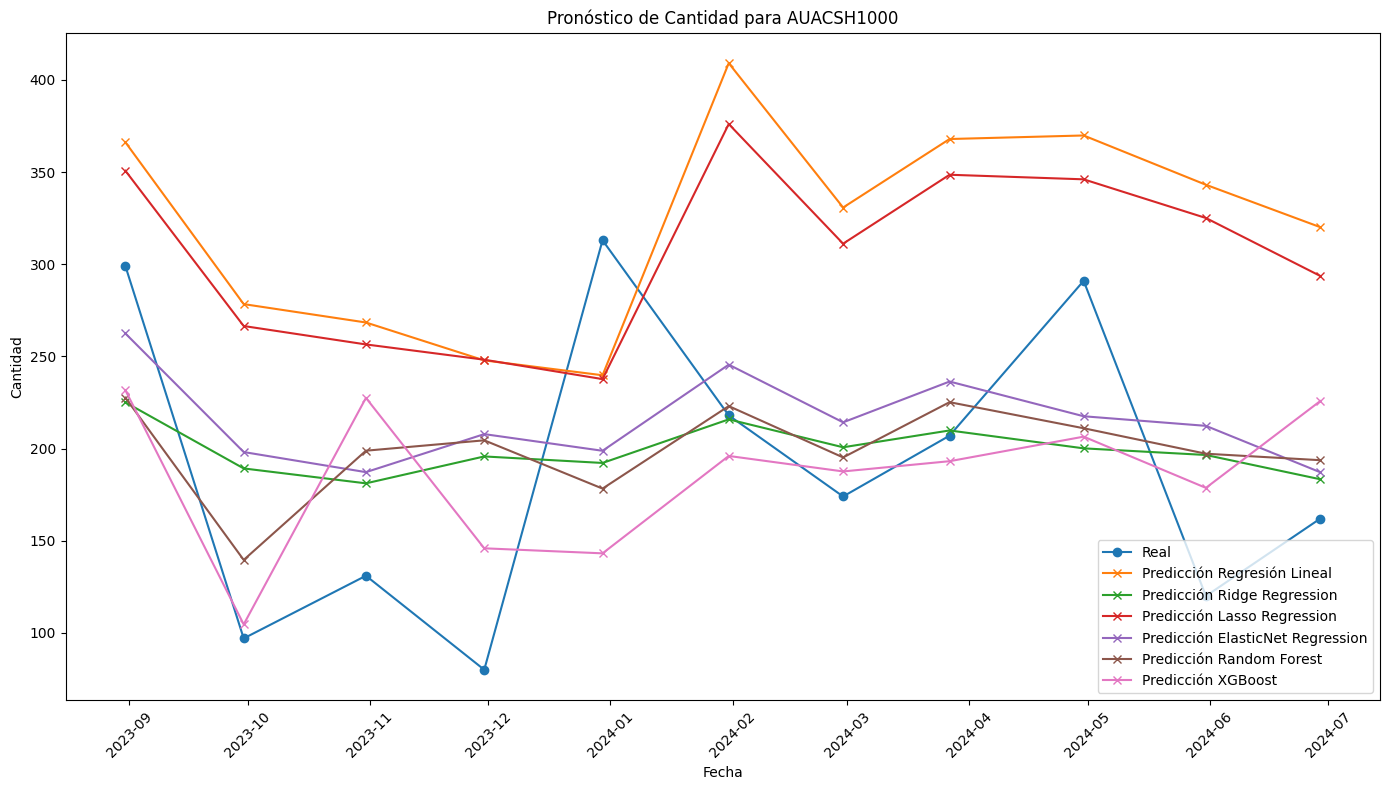

In [ ]:
# Seleccionar un artículo para visualizar
articulo_ejemplo = 'AUACSH1000'  # Reemplaza con un códigos

# Filtrar los resultados para el artículo seleccionado
resultado_articulo = df_resultados_finales[df_resultados_finales['codigoarticulo'] == articulo_ejemplo]

# Verificar si hay predicciones disponibles
modelos_disponibles = ['Regresión Lineal', 'Ridge Regression', 'Lasso Regression', 'ElasticNet Regression', 'Random Forest', 'XGBoost']
predicciones = {}
for modelo in modelos_disponibles:
    pred_col = f'{modelo}_Predicciones'
    if pred_col in resultado_articulo.columns:
        predicciones[modelo] = resultado_articulo.iloc[0][pred_col]

# Verificar que haya al menos un modelo con predicciones
if not predicciones:
    print(f"No hay predicciones disponibles para el artículo {articulo_ejemplo}.")
else:
    # Obtener los datos reales
    df_art_ejemplo = df_feat[df_feat['codigoarticulo'] == articulo_ejemplo].copy().reset_index(drop=True)
    train_size_art = int(len(df_art_ejemplo) * 0.8)
    test_df_art = df_art_ejemplo.iloc[train_size_art:].copy()
    y_true = test_df_art[target].values

    # Crear DataFrame para visualizar las predicciones de diferentes modelos
    df_plot = pd.DataFrame({
        'fecha': test_df_art['fecha'],
        'Real': y_true
    })

    for modelo, preds in predicciones.items():
        df_plot[modelo] = preds

    # Graficar todas las predicciones
    plt.figure(figsize=(14,8))
    plt.plot(df_plot['fecha'], df_plot['Real'], label='Real', marker='o')

    for modelo in modelos_disponibles:
        if modelo in predicciones:
            plt.plot(df_plot['fecha'], df_plot[modelo], label=f'Predicción {modelo}', marker='x')

    plt.xlabel('Fecha')
    plt.ylabel('Cantidad')
    plt.title(f'Pronóstico de Cantidad para {articulo_ejemplo}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()